##**General conditions and first task**

###We have the following Dirichlet task:
$$
\begin{cases}
-a \frac{\partial^{2}u}{\partial x^{2}} - b \frac{\partial^{2}u}{\partial x^2} = f(x.y), \quad (x,y) \in D \\
u(x,y) = \phi(x,y), \quad (x,y) \in \partial D
\end{cases}
$$

###In our case we will consider:
$$
a = 1.1, \quad b = 0.8 \\
f(x,y) = 1.1sin(x) + (3.2x^{2}+4.4y^{2})cos(2xy) \\
\phi(x,y) = sin(x) + cos(2xy)
$$

###We also have the following difference schema (operator):
$$
h_{x} = h_{y} = h = \frac{1}{m} \\
-a \frac{U_{i-1,j}-2U_{i,j}+U_{i+1,j}}{h^2} - b \frac{U_{i-1,j}-2U_{i,j}+U_{i,j+1}}{h^2} = f_{i,j}
$$

### Our area $D$ have the folowing view:
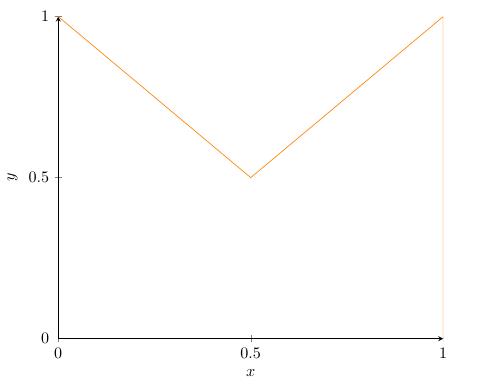

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [ ]:
class Dirichlet_task:
  # Initial functions
  def f(self,x,y):
    # return 6*x + 4
    return 1.1*math.sin(x) + (3.2*(x**2) + 4.4*(y**2))*math.cos(2*x*y)

  def phi(self,x,y):
    # return x**3 + y**2
    return math.sin(x) + math.cos(2*x*y)
  
  def __init__(self, h, a, b):
    self.h = h
    self.N = round(1/self.h)
    self.a = a
    self.b = b

    # define set of indices according to our area D and boundary
    indices = []
    boundary = []
    # lower, right and left boundaries
    for j in range(self.N+1):
      boundary.append((0,j))
    for i in range(self.N+1):
      boundary.append((i,0))
    for j in range(self.N+1):
      boundary.append((self.N, j))
    # two remained parts
    for j in range(round(self.N/2), self.N+1):
      i = self.N - j
      boundary.append((i,j))
    for j in range(round(self.N/2), self.N+1):
      i = j
      boundary.append((i,j))

    # 1 part - lower rectangle
    for i in range(1,self.N):
      for j in range(1, round(self.N/2)):
        indices.append((i, j))

    # 2 part - left triangle:
    for j in range(round(self.N/2), self.N):
      for i in range(1, self.N-j):
        indices.append((i, j))

    # 3 part - right triangle:
    for i in range(round(self.N/2), self.N):
      for j in range(round(self.N/2), i):
        indices.append((i, j))

    self.indices = indices
    self.boundary = boundary


  def dot_product(self, A, B):
    res = 0
    for i,j in self.indices:
      res += A[i][j]*B[i][j]
    return res

  def init_matrix(self):
    X = np.zeros((self.N+1, self.N+1))
    for i,j in self.indices:
      X[i][j] = 1
    return X

  def norm(self, A):
    return (self.dot_product(A,A))**0.5

  def normalize(self, A):
    return A/self.norm(A) 

  def grid_norm(self, A):
    return self.norm(A)*self.h
  
  def impl_oper(self, U):
    Y = np.zeros((self.N+1, self.N+1))
    for i,j in self.indices:
      Y[i][j] = -self.a*(U[i-1][j]-2*U[i][j]+U[i+1][j])/(self.h**2) - self.b*(U[i][j-1]-2*U[i][j]+U[i][j+1])/(self.h**2)
    return Y


  def find_eigenvalues(self, delta):
    def next_step_reversed(U, lambda_max):
      Y = np.zeros((self.N+1, self.N+1))
      for i,j in self.indices:
        Y[i][j] = lambda_max*U[i][j] + self.a*(U[i-1][j]-2*U[i][j]+U[i+1][j])/(self.h**2) + self.b*(U[i][j-1]-2*U[i][j]+U[i][j+1])/(self.h**2)
      return Y

    # Step: 3
    # Define our matrix woth zeroes boundary values and comute first approximation for lambda max
    Y = self.init_matrix()
    Y = self.normalize(Y)
    Z = self.impl_oper(Y)
    print(Y[1][1], Y[2][2])

    lambda_prev = 10
    lambda_current = self.dot_product(Z,Y)

    count_max = 0

    while abs((lambda_current/lambda_prev) -1) > delta:
      count_max += 1
      Y = Z.copy()
      Y = self.normalize(Y)
      Z = self.impl_oper(Y)
      
      lambda_prev = lambda_current
      lambda_current = self.dot_product(Z,Y)

    lambda_max = lambda_current
    # Now we will search lambda_min
    X = self.init_matrix()
    X = self.normalize(X)
    Z = next_step_reversed(X, lambda_max)

    lambda_prev = lambda_max
    lambda_current = self.dot_product(Z,X)

    count_min = 0

    while abs((lambda_current/lambda_prev) -1) > delta:
      count_min += 1
      Y = Z.copy()
      Y = self.normalize(Y)
      Z = next_step_reversed(Y, lambda_max)
      
      lambda_prev = lambda_current
      lambda_current = self.dot_product(Z,Y)
    
    lambda_min = lambda_max - lambda_current

    # print(lambda_max, lambda_min)
    return lambda_max, count_max, lambda_min, count_min

  def minres_method(self, delta):
    def next_step(U, i, j):
      return -self.a*(U[i-1][j]-2*U[i][j]+U[i+1][j])/(self.h**2) - self.b*(U[i][j-1]-2*U[i][j]+U[i][j+1])/(self.h**2) - self.f(i*self.h, j*self.h)

    # Step 0: define answer
    Answ = np.zeros((self.N+1, self.N+1))
    for i,j in self.indices:
      Answ[i][j] = self.phi(i*self.h, j*self.h)
    for i,j in self.boundary:
      Answ[i][j] = self.phi(i*self.h, j*self.h)
    # print(Answ)

    # Step 1: initial discrepancy and initial matrix
    X = self.init_matrix()
    for i, j in self.boundary:
      X[i][j] = self.phi(i*self.h, j*self.h)

    # matrix of discrepancy (two first steps)
    D_prev = np.zeros((self.N+1, self.N+1))
    D = np.zeros((self.N+1, self.N+1))
    for i,j in self.indices:
      D[i][j] = next_step(X, i, j)
    # print(D)
    S = self.impl_oper(D)
    Xi_1 = S/(self.norm(S))
    Xi_2 = D/(self.norm(S))
    tau = self.dot_product(Xi_1, Xi_2)
    Y = X.copy()
    count = 0

    while self.norm(D-D_prev)*self.h > delta or count == 0:
      count += 1
      D_prev = D.copy()
      X = Y.copy()

      for i,j in self.indices:
        Y[i][j] = X[i][j] - tau*D[i][j]
      for i,j in self.boundary:
        Y[i][j] = self.phi(i*self.h, j*self.h)
      for i,j in self.indices:
        D[i][j] = next_step(Y, i, j)
      S = self.impl_oper(D)
      Xi_1 = S/(self.norm(S))
      Xi_2 = D/(self.norm(S))
      tau = self.dot_product(Xi_1, Xi_2)
      # if count == 1:
        # print(Y, self.norm(Y-Answ)*self.h)
      # print(tau)
      # print(self.norm(D-D_prev)*self.h)
    print(count)

    return self.norm(Y-Answ)*self.h

  def over_relaxation_method(self, delta):
    def next_step(U, i, j):
      return -self.a*(U[i-1][j]-2*U[i][j]+U[i+1][j])/(self.h**2) - self.b*(U[i][j-1]-2*U[i][j]+U[i][j+1])/(self.h**2) - self.f(i*self.h, j*self.h)

    # Step 0: define answer
    _, _, lambda_min, _ = self.other_eigenvalues(1e-10)
    omega = 2/(1 + (1 - (lambda_min)**2)**0.5 )  # parameter of method
    print(omega)

    Answ = np.zeros((self.N+1, self.N+1))
    for i,j in self.indices:
      Answ[i][j] = self.phi(i*self.h, j*self.h)
    for i,j in self.boundary:
      Answ[i][j] = self.phi(i*self.h, j*self.h)
    # print(Answ)

    # Step 1: initial matrix
    count = 0
    X = self.init_matrix()
    for i, j in self.boundary:
      X[i][j] = self.phi(i*self.h, j*self.h)
    Y = np.zeros((self.N+1, self.N+1))

    # Step 2: iterations
    while abs(Y-X).max() > delta or count == 0:
      count += 1
      X = Y.copy()
      Z = 0

      # Relaxation method
      for i,j in self.indices:
        Z = (1/(2*(self.a+self.b)))*(self.a*(Y[i-1][j] + X[i+1][j]) + self.b*(Y[i][j-1] + X[i][j+1]) + (self.h**2)*self.f(i*self.h, j*self.h))
        Y[i][j] = (1-omega)*X[i][j] + omega*Z
      for i,j in self.boundary:
        Y[i][j] = self.phi(i*self.h, j*self.h)

    print(count)
    # set axis and shape
    fig, ax = plt.subplots(figsize=(10, 10))

    # plot approximate solution
    x = [self.h*i for i in range(0, int(self.N/2))]
    y = Y[int(self.N/2), 0:int(self.N/2)]
    ax.plot(x, y, color='red', label='numerical solution')

    # plot exact solution
    y = Answ[int(self.N/2), 0:int(self.N/2)]
    ax.plot(x, y, color='black', label='exact solution')
    plt.legend()

    return self.norm(Y-Answ)*self.h

  # eigenvalue for parametr of overrelaxation
  def other_eigenvalues(self, delta):
    def next_step_reversed(U, lambda_max):
      Y = np.zeros((self.N+1, self.N+1))
      for i,j in self.indices:
        Y[i][j] = lambda_max*U[i][j] - self.h**2*(-self.a*(U[i-1][j]+U[i+1][j])/(self.h**2) - self.b*(U[i][j-1]+U[i][j+1])/(self.h**2))/((2*(self.a + self.b)) )
      return Y

    def oper(U):
      Y = np.zeros((self.N+1, self.N+1))
      for i,j in self.indices:
        Y[i][j] = (-self.a*(U[i-1][j]+U[i+1][j])/(self.h**2) - self.b*(U[i][j-1]+U[i][j+1])/(self.h**2))
        Y[i][j] = self.h**2 * Y[i][j]/(2*(self.a + self.b))
      return Y

    # Step: 3
    # Define our matrix woth zeroes boundary values and comute first approximation for lambda max
    Y = self.init_matrix()
    Y = self.normalize(Y)
    Z = oper(Y)

    lambda_prev = 10
    lambda_current = self.dot_product(Z,Y)

    count_max = 0

    while abs((lambda_current/lambda_prev) -1) > delta:
      count_max += 1
      Y = Z.copy()
      Y = self.normalize(Y)
      Z = oper(Y)
      
      lambda_prev = lambda_current
      lambda_current = self.dot_product(Z,Y)

    lambda_max = lambda_current
    # Now we will search lambda_min
    X = self.init_matrix()
    X = self.normalize(X)
    Z = next_step_reversed(X, lambda_max)

    lambda_prev = lambda_max
    lambda_current = self.dot_product(Z,X)

    count_min = 0

    while abs((lambda_current/lambda_prev) -1) > delta:
      count_min += 1
      Y = Z.copy()
      Y = self.normalize(Y)
      Z = next_step_reversed(Y, lambda_max)
      
      lambda_prev = lambda_current
      lambda_current = self.dot_product(Z,Y)
    
    lambda_min = lambda_max - lambda_current

    # print(lambda_max, lambda_min)
    return lambda_max, count_max, lambda_min, count_min

### Required constants

In [ ]:
delta = 1e-3
h = 1/40
a = 1.1
b = 0.8
# a = b = 1

### Test

1.8071944028165452
56


0.00048236845871352913

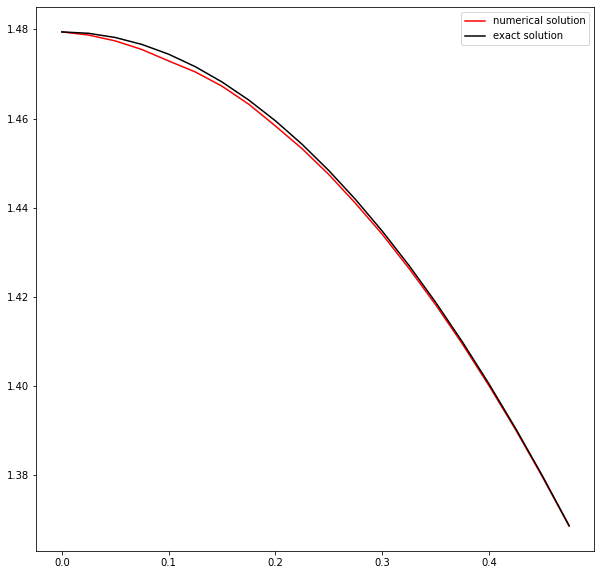

In [ ]:
eq = Dirichlet_task(h, a, b)
# eq.find_eigenvalues(delta)
# eq.minres_method(delta)
# eq.other_eigenvalues(delta)
eq.over_relaxation_method(delta)

### Table for first task

In [ ]:
d = 1e-6
h=0.1
eq = Dirichlet_task(h, a, b)
eq.find_eigenvalues(d)

0.1336306209562122 0.1336306209562122


(725.1705915680153, 75, 34.828809649606455, 46)

In [ ]:
delta = [1e-4, 1e-6, 1e-7]
h_values = [1/10, 1/20, 1/40]
print()
for d in delta:
  for h in h_values:
    eq = Dirichlet_task(h, a, b)
    res = eq.find_eigenvalues(d)
    print(res, '\t')
  print()


(724.7591823643688, 44, 35.138917161133804, 19) 	
(2996.79818833676, 90, 39.295005716866854, 28) 	
(12034.36578152808, 89, 65.38002458168012, 22) 	

(725.1705915680153, 75, 34.828809649606455, 46) 	
(3005.1194467823743, 217, 34.87392458611839, 115) 	
(12124.013106038428, 563, 35.65865384604149, 229) 	

(725.1744348535744, 91, 34.82557352946594, 60) 	
(3005.1875072256835, 278, 34.8122350753024, 171) 	
(12125.172347504675, 809, 34.81410075524582, 416) 	



### Table for second task

In [ ]:
# delta = [1e-8, 1e-4, 1e-6, 1e-7]
delta = [1e-1, 1e-2, 1e-3, 1e-4]
h_values = [1/10, 1/20, 1/40]
print()
for d in delta:
  for h in h_values:
    eq = Dirichlet_task(h, a, b)
    res = eq.minres_method(d)
    print(res, '\t')
  print()


39
0.005827641591292516 	
129
0.0129032067469915 	
398
0.026389983722912316 	

63
0.0005432908461206914 	
228
0.0012790543577275062 	
796
0.0026562513508478504 	

87
3.029181472311338e-05 	
327
0.00011880816701732703 	
1195
0.0002643210750088836 	

111
3.860791211450786e-05 	
426
6.5535406826080155e-06 	
1595
2.4242690353549204e-05 	



### Table for third task


47
0.00012655436416677087 	
154
0.0007967127340543808 	
492
0.0033756115820821105 	

71
4.219416597949297e-05 	
253
6.554760665928471e-06 	
894
3.158021855420566e-05 	

83
4.322824877791781e-05 	
303
1.0502079525281056e-05 	
1095
1.849673306671244e-06 	

94
4.332986890220722e-05 	
353
1.1084712417707098e-05 	
1296
2.5336328603675157e-06 	



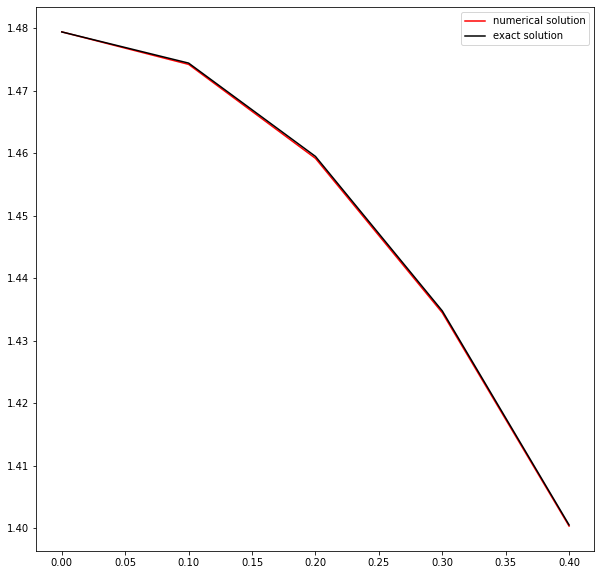

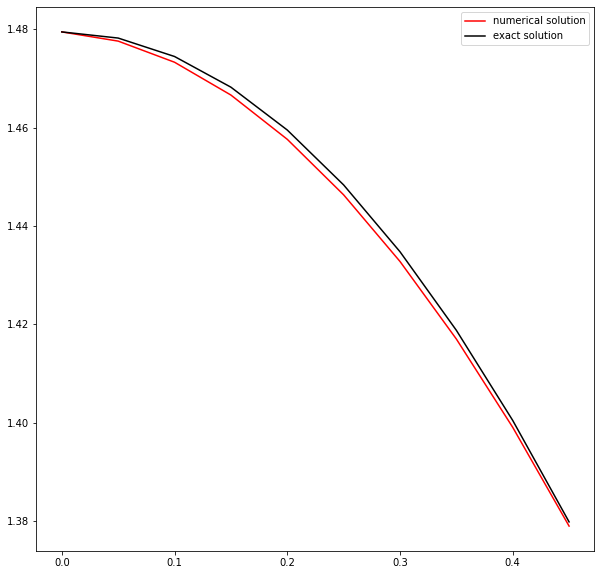

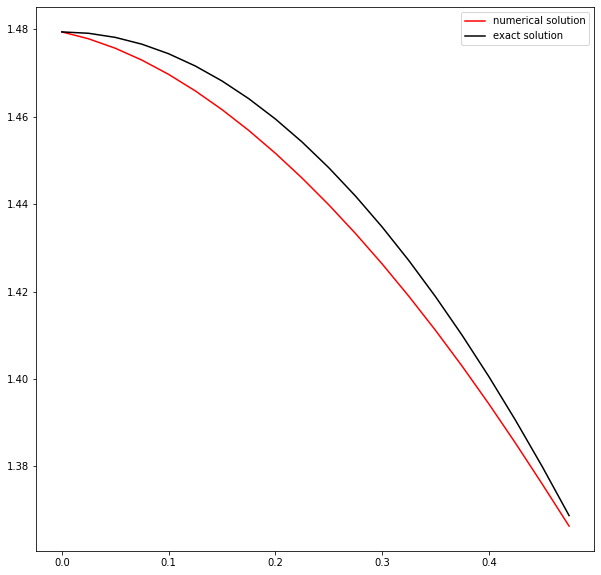

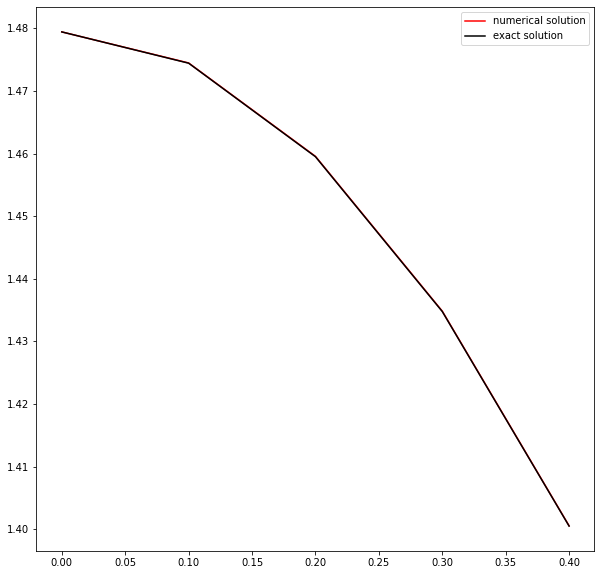

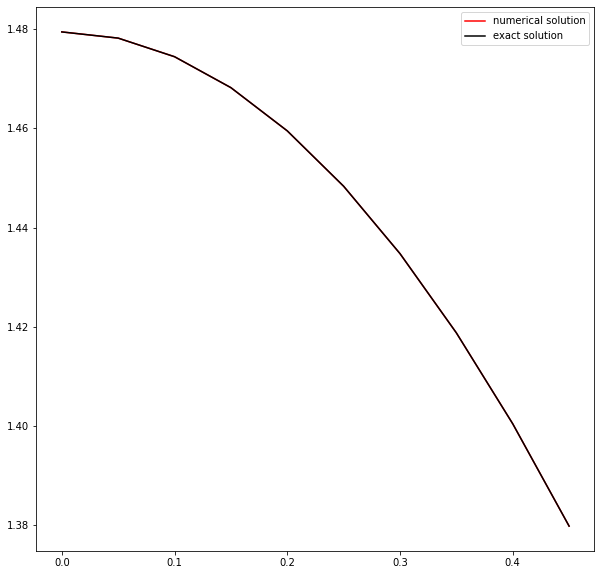

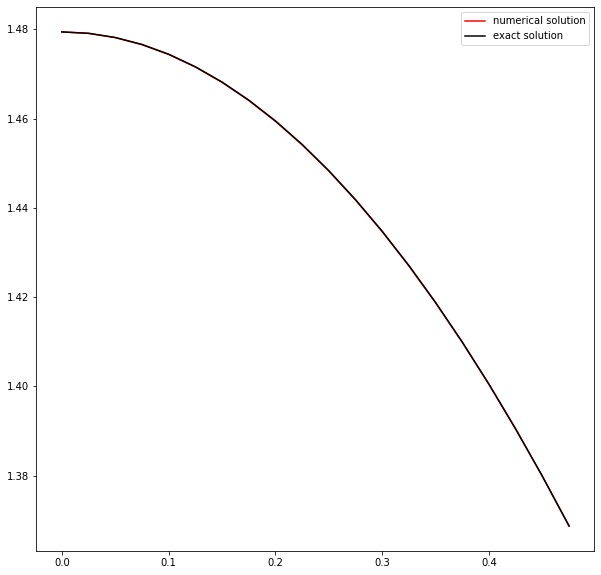

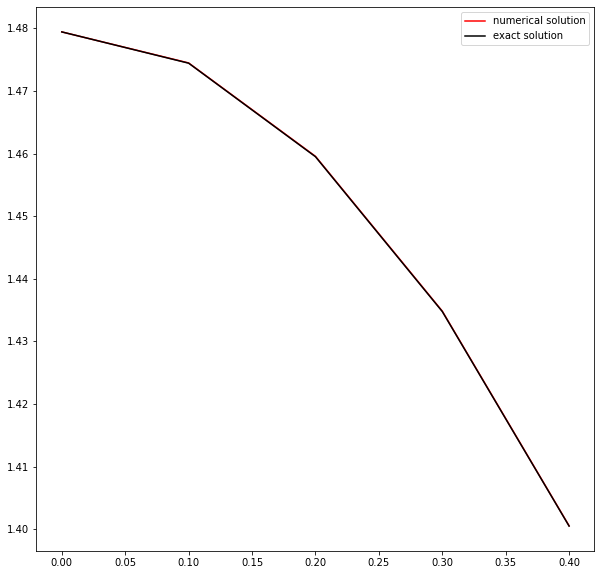

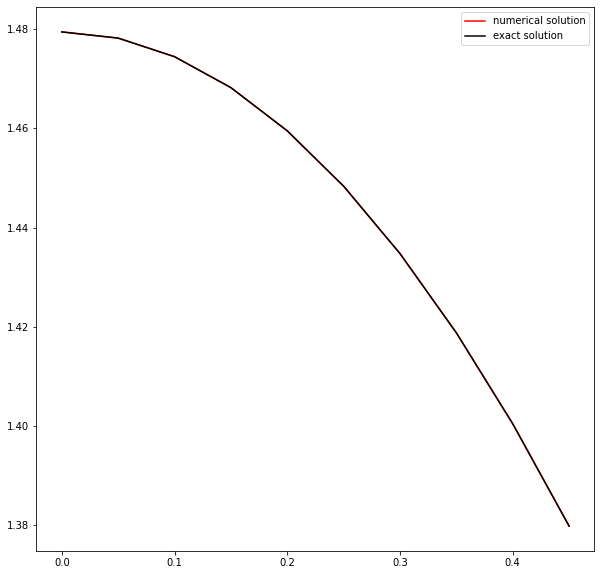

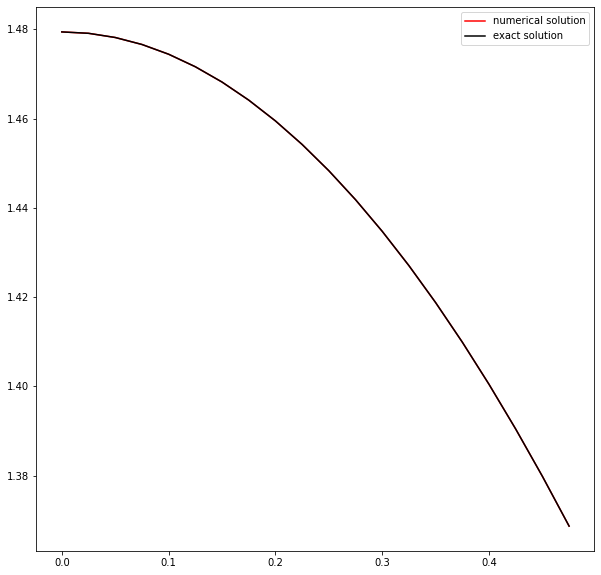

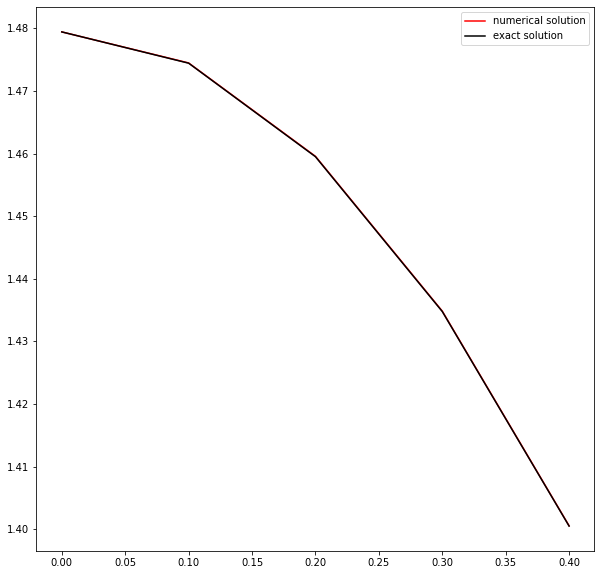

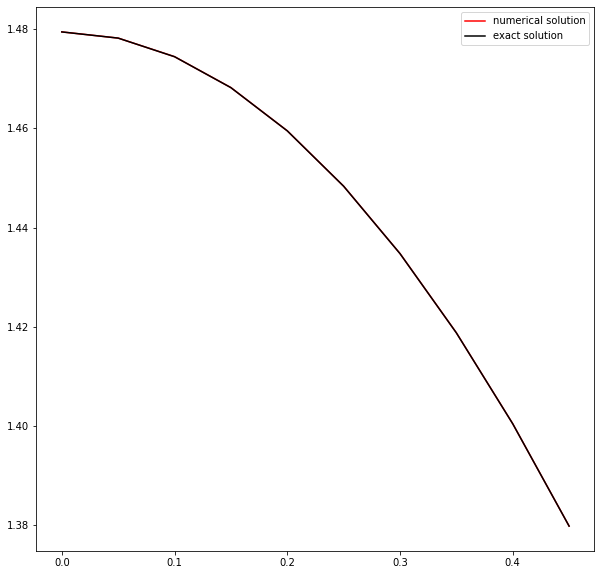

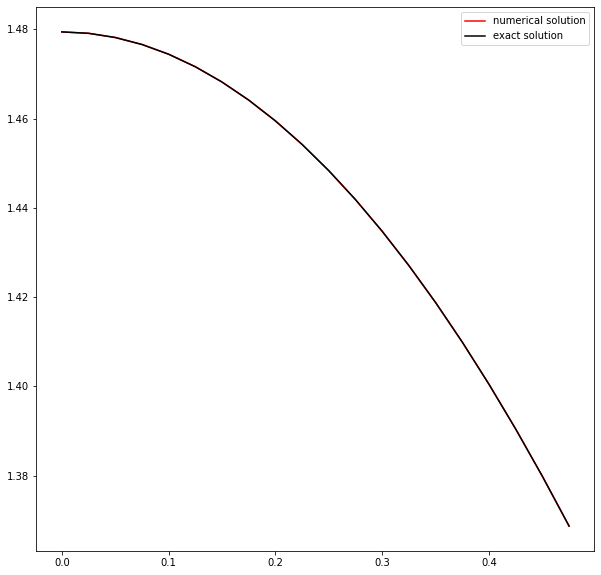

In [ ]:
delta = [1e-4, 1e-6, 1e-7, 1e-8]
# delta = [1e-1, 1e-2, 1e-3, 1e-4]
h_values = [1/10, 1/20, 1/40]
print()
for d in delta:
  for h in h_values:
    eq = Dirichlet_task(h, a, b)
    res = eq.over_relaxation_method(d)
    print(res, '\t')
  print()